## Importing essential libraries:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob
import json
import re
from bs4 import BeautifulSoup 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from keras.layers.embeddings import Embedding

## Data Preprocessing:

In [8]:
df = pd.read_csv('/content/Flipkart_Amazon Mobile Reviews.csv', index_col=0)

In [9]:
df.rename(columns={"Review-Title": "comment", "rating": "stars", "Review-Body": "Model", "Product Name": "Brand"}, inplace=True)
df.head()

,comment,stars,Model,Brand
0,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
1,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
2,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
3,One plus losing is originality!!!,3.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."
4,Read,1.0 out of 5 stars,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12..."


## Exploratory Data Analysis

In [10]:
df.stars.value_counts()

5.0 out of 5 stars    9399
1.0 out of 5 stars    5231
4.0 out of 5 stars    4886
3.0 out of 5 stars    2703
2.0 out of 5 stars    1558
Name: stars, dtype: int64

In [11]:
## Replacing the text in the column 'stars' to required ratings integer values.

df["stars"].replace({"5.0 out of 5 stars": 5,
                     "4.0 out of 5 stars": 4,
                     "3.0 out of 5 stars": 3,
                     "2.0 out of 5 stars": 2,
                     "1.0 out of 5 stars": 1}, inplace=True)

df["stars"].value_counts()

5    9399
1    5231
4    4886
3    2703
2    1558
Name: stars, dtype: int64

In [12]:
## Summarizing the data we have

print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand']))))
print("\nTotal number of unique products: ", len(list(set(df['Model']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%".format(df[df['stars']==3]["comment"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%".format(df[df['stars']>3]["comment"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%".format(df[df['stars']<3]["comment"].count()/len(df)*100))

Summary statistics of numerical features : 
               stars
count  23777.000000
mean       3.490558
std        1.578505
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        5.000000

Total number of reviews:  23777

Total number of brands:  8

Total number of unique products:  18598

Percentage of reviews with neutral sentiment : 11.37%

Percentage of reviews with positive sentiment : 60.07%

Percentage of reviews with negative sentiment : 28.55%


Text(0, 0.5, 'Count')

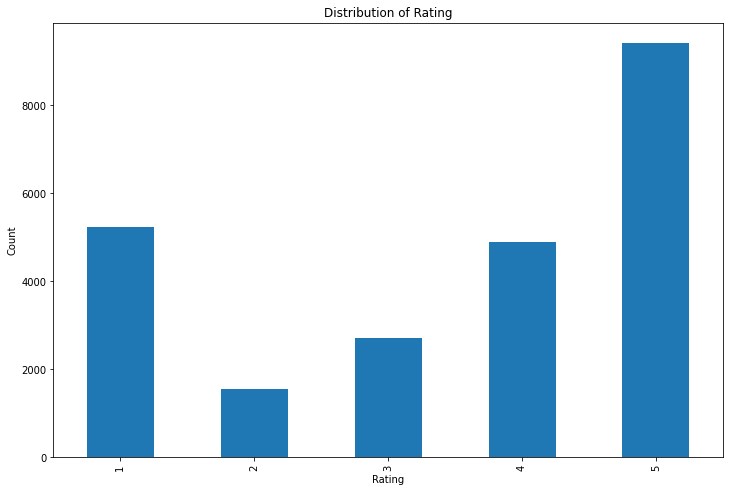

In [13]:
# Plotting distribution of rating

plt.figure(figsize=(12,8))
df['stars'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for different Brands')

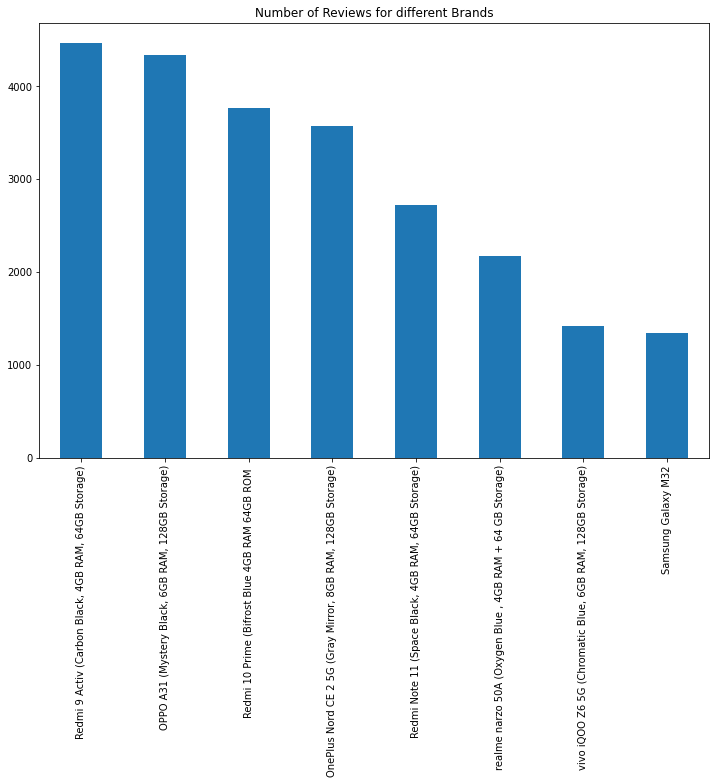

In [14]:
# Plotting  number of Reviews for different Brands

brands = df["Brand"].value_counts()
plt.figure(figsize=(12,8))
brands[:].plot(kind='bar')
plt.title("Number of Reviews for different Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 10 Products')

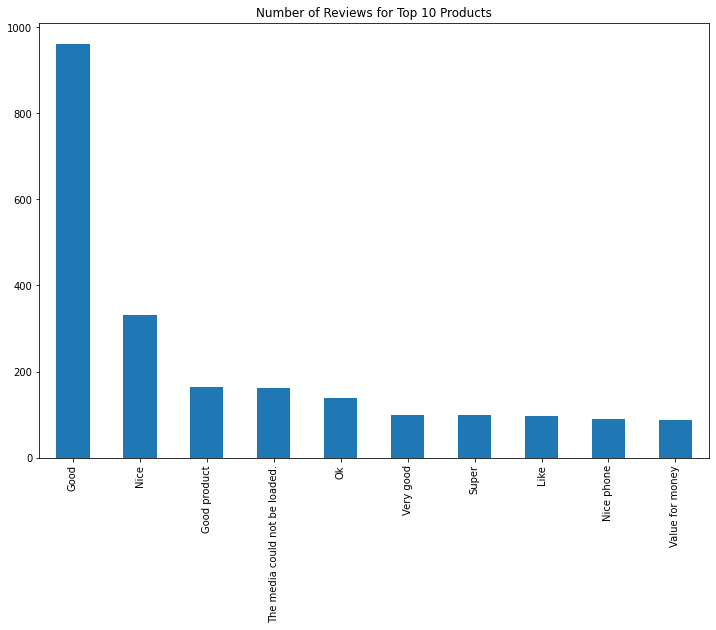

In [15]:
# Plotting number of reviews for all brands

products = df["Model"].value_counts()
plt.figure(figsize=(12,8))
products[:10].plot(kind='bar')
plt.title("Number of Reviews for Top 10 Products")

Text(0, 0.5, 'Count')

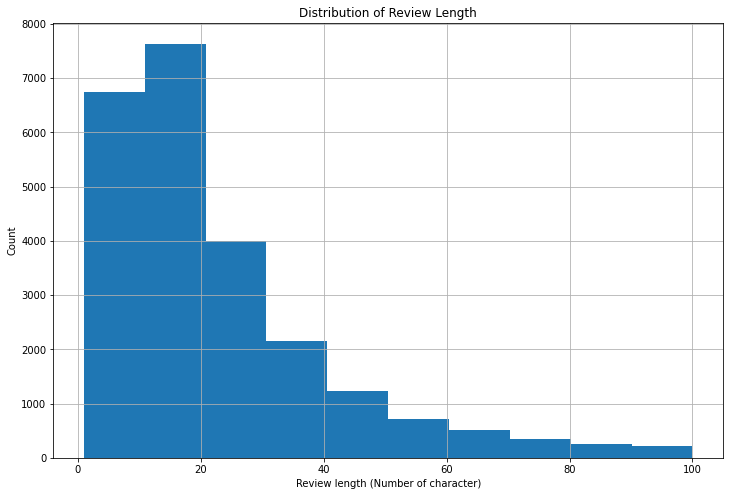

In [16]:
# Plotting distribution of review length

review_length = df["comment"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [17]:
# Dropping missing values

df.dropna(inplace=True)

# Considering reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2)
# and dropping reviews with neutral sentiment (rating 3).

df = df[df['stars'] != 3]

# Encoding 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['stars'] > 3, 1, 0)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,comment,stars,Model,Brand,Sentiment
0,Worst phone ever,1,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",0
1,Ok !!! Not up to the mark,2,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",0
2,Awesome look,5,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1
4,Read,1,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",0
5,Fantastic but some bug fixes required!,4,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1


In [18]:
# Spliting data into training set and validation


X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['Sentiment'], test_size=0.3, random_state=0)

print('Loading %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))

Loading 14356 training examples and 6153 validation examples. 



### Creating a Bag of Words representation and Text Preprocessing:

To classify the reviews into positive and negative sentiment, We first need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's how we're planning to dpo it.

1. Preprocess raw reviews to cleaned reviews
2. Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
3. Transform review text to numerical representations (feature vectors)
4. Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
5. Improve the model performance by GridSearch

In [19]:
# Creating a function to do text preprocessing
## 1. Remove html tags using BeautifulSoup
## 2. Remove non-character such as digits and symbols
## 3. Convert to lower case
## 4. Remove stop words such as "the" and "and" if needed
## 5. Convert to root words by stemming if needed

def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    
    #removing html
    text = BeautifulSoup(raw_text, 'lxml').get_text() 
    
    # Removing non-character
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # converting to lower case
    words = letters_only.lower().split()  
    
    # Removing stopword
    if remove_stopwords: 
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    # Stemming
    if stemming==True: 
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
    
    # Spliting text    
    if split_text==True:  
        return (words)
    
    return( " ".join(words))

In [20]:
# Preprocessing text data in training set and validation set

X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Showing a cleaned review in the training set : \n\n',  X_train_cleaned[1])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Showing a cleaned review in the training set : 

 we can buy this product


In [21]:
# Fitting and transform the training data to a document-term matrix using CountVectorizer

countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier

mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 3655 

Show some feature names : 
 ['aa', 'ekdum', 'mobial', 'smoothness']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


MultinomialNB()

In [22]:
# Defining a function check the Model Evalutaion Metrices

def modelEvaluation(predictions):
    
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [23]:
# Evaluating the model on validaton set

predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8750

AUC score : 0.8469

Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1994
           1       0.89      0.93      0.91      4159

    accuracy                           0.88      6153
   macro avg       0.86      0.85      0.85      6153
weighted avg       0.87      0.88      0.87      6153


Confusion Matrix : 
 [[1529  465]
 [ 304 3855]]


In [24]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 


tfidf = TfidfVectorizer(min_df=5) # Taking a minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names()))
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

#  Instatiating and fitting Logistic Regression object

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 828 

Show some feature names : 
 ['000']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LogisticRegression()

In [25]:
# Looking at the top 10 features with smallest and the largest coefficients

feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



Top 10 features with smallest coefficients :
['worst' 'not' 'don' 'waste' 'poor' 'bad' 'defective' 'pathetic' 'hang'
 'bakwas']

Top 10 features with largest coefficients : 
['best' 'nice' 'good' 'awesome' 'excellent' 'amazing' 'great' 'super'
 'budget' 'superb']


In [26]:
# Evaluating on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8901

AUC score : 0.8613

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      1994
           1       0.90      0.94      0.92      4159

    accuracy                           0.89      6153
   macro avg       0.88      0.86      0.87      6153
weighted avg       0.89      0.89      0.89      6153


Confusion Matrix : 
 [[1554  440]
 [ 236 3923]]


## GridSearch CV

In [27]:
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.8957

AUC score : 0.8719

Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1994
           1       0.91      0.94      0.92      4159

    accuracy                           0.90      6153
   macro avg       0.89      0.87      0.88      6153
weighted avg       0.89      0.90      0.89      6153


Confusion Matrix : 
 [[1604  390]
 [ 252 3907]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [28]:
df_cleaned_text= pd.Series(X_train_cleaned+X_test_cleaned)
df_cleaned_text.head()

0                   value for money
1           we can buy this product
2    nice phone in reasonable price
3                              mast
4             very good oneplus phn
dtype: object

In [29]:

df_predicted= df[['Model', 'Sentiment']]
df_predicted['Cleaned Review']= df_cleaned_text
df_predicted= df_predicted[['Model', 'Cleaned Review', 'Sentiment']]
df_predicted.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Model,Cleaned Review,Sentiment
0,Hang problem,value for money,0
1,I'm writing this review after using 3days !!!B...,we can buy this product,0
2,Camera is so good n very fast phone back look ...,nice phone in reasonable price,1
4,I got my delivery on 23 feb when I unboxed the...,very good oneplus phn,0
5,The media could not be loaded.\n ...,gst not providing,1
